In [1]:
!pip install qiskit qiskit-aer matplotlib

Could not find platform independent libraries <prefix>


### initialization

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np

# --- Parameters ---
m = 3 # Number of qubits for the data registers (D = 2^m = 8)
D = 2**m
r_prime = 0 # Assume r'_i = 0 for simplicity

# Inputs (example values in Z_8)
w_i = 5 # Alice's data: w_i = 5
s_i = 2 # Bob's data: s_i = 2

# Expected Result: D_i = (-1)^0 * (5 - 2) mod 8 = 3
expected_Di = (w_i - s_i) % D
print(f"Expected Decoded Result (D_i): {expected_Di}")

# Initialize Registers
# T_i: The final result register (m qubits)
T_i = QuantumRegister(m, 'T')
# W_i: Alice's data register (m qubits)
W_i = QuantumRegister(m, 'W')
# S_i: Bob's data register (m qubits)
S_i = QuantumRegister(m, 'S')
# Classical Register for Measurement
c = ClassicalRegister(m, 'c')

qc = QuantumCircuit(T_i, W_i, S_i, c)

Expected Decoded Result (D_i): 3


### 1. Entangled state distribution (Preparation of T_i)

In [3]:
## 1. Entangled state distribution (Preparation of T_i)
qc.h(T_i)

## 1. Entangled state distribution (Copy T_i state to W_i and S_i via CNOT)
# For j in T_i, copy to W_i and S_i
for k in range(m):
    qc.cx(T_i[k], W_i[k])
    qc.cx(T_i[k], S_i[k])

qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "T"), index=0>, <Qubit register=(3, "T"), index=1>, <Qubit register=(3, "T"), index=2>, <Qubit register=(3, "W"), index=0>, <Qubit register=(3, "W"), index=1>, <Qubit register=(3, "W"), index=2>, <Qubit register=(3, "S"), index=0>, <Qubit register=(3, "S"), index=1>, <Qubit register=(3, "S"), index=2>), clbits=())

### Step 2: Local Phase Encoding

In [4]:
# --- Helper function for applying the modular phase encoding ---
def apply_modular_phase_encoding(qc, target_reg, data_value, is_alice):
    """Applies the phase shift operation controlled by data_value on the target register."""

    # Determine the sign for the phase
    # Alice: phase = ((-1)**r_prime * data_value)
    # Bob: phase = ((-1)**(r_prime + 1) * data_value)
    sign = (-1)**r_prime if is_alice else (-1)**(r_prime + 1)

    # The phase angle for the least significant qubit (k=0) is 2pi * data_value / D
    # For a Controlled-Phase operation P(theta) on T_i controlled by W_i, we apply a series
    # of controlled P gates corresponding to the binary decomposition of data_value.

    # In the QBC protocol, the operation ROT(x) is applied on the state T_i
    # conditioned on the state of the data register W_i or S_i.
    # The simplest way to implement: Apply the overall phase operation $\sum_j \zeta^{jx} \ket{j}$
    # on T_i, but this requires an operation *controlled* by the full state of W_i/S_i.

    # A simpler and more common implementation of this *rotation* is via a series of
    # controlled-rotations based on the QFT structure.

    # For this simplified protocol implementation, we model the *effect* on the T_i register
    # which is a phase shift proportional to the value of the data register.
    # The state is $\sum_{j} \ket{j}_{T_i} \ket{j}_{W_i} \ket{j}_{S_i}$.
    # After encoding: $\sum_{j} \zeta^{j \cdot (\text{Alice Phase})} \ket{j}_{T_i} \ket{j}_{W_i} \ket{j}_{S_i}$ (This interpretation is slightly off for the protocol).

    # Correct Interpretation (Based on QFT phase encoding):
    # The operation ROT(x) is $\ket{j} \to e^{i \frac{2\pi}{D} j x} \ket{j}$.
    # In the standard QFT framework, this is implemented on the $T_i$ register,
    # controlled by the *qubits* of $W_i$ (or $S_i$).

    # Gate on T_i[k] is controlled by W_i[l] with phase: sign * data_value / (2^(m-1-k+l))
    # This is complex. Let's use the simplest version of the phase-encoding gate
    # which is implemented using controlled rotations $R_k$.


    # Standard phase encoding for a value 'x' in the QFT setting:
    # We want to apply an operator $\ket{j} \to e^{i\frac{2\pi}{D} j x}\ket{j}$ to the target register.
    # This is equivalent to applying $CR_k$ gates controlled by the bits of $x$.

    data_register = W_i if is_alice else S_i

    # The value 'data_value' must be encoded onto the register data_register first for this
    # gate to be correctly controlled by the *classical* value $w_i$.
    # Since the protocol says Alice/Bob apply the phase encoding **locally** on $W_i/S_i$ *respectively*
    # but the result shows the phase is applied to $T_i$:
    # $\frac{1}{\sqrt{D}}\sum_{j}\zeta^{j(-1)^{r'_i}(w_i-s_i)}\ket{j}$
    # This means the operation must have been $\text{PhaseShift}((-1)^{r'_i}w_i)$ on $T_i$,
    # effectively controlled by the *quantum state* of $W_i$, and $\text{PhaseShift}((-1)^{r'_i+1}s_i)$
    # on $T_i$, controlled by $S_i$.

    # Since W_i and S_i are $\ket{j}$ states, the only way to get the final phase is
    # to apply the phase to the $T_i$ register, controlled by the $j$ value of $W_i$ and $S_i$.

    # We must first encode the classical value $w_i$ (or $s_i$) into the register $W_i$ (or $S_i$)
    # to have a standard quantum circuit. The protocol description assumes $W_i$ and $S_i$
    # are registers representing $w_i$ and $s_i$, which is achieved by the initial state prep.
    # Thus, $W_i$ is effectively a quantum state of $w_i$ and $S_i$ is $s_i$.

    # --- Implementing the phase shift $ROT(x)$ controlled by $W_i$ (or $S_i$) on $T_i$ ---
    # The phase is: $\text{sign} \cdot \frac{2\pi}{D} \cdot \text{data\_value}$.

    # This is implemented by a series of controlled phase gates:
    for k in range(m): # k = index of the control qubit W_i/S_i
        theta = sign * (data_value / (2**(m-k))) * 2 * np.pi

        # Apply the rotation $P(\theta)$ on T_i[k] controlled by W_i/S_i[k]
        # P(theta) is equivalent to Rz(theta) followed by a global phase
        # But this is still not quite right for the QFT phase encoding.

        # The correct phase encoding for $\ket{j} \to e^{i 2\pi j x/D}\ket{j}$ is:
        # $P_k$ (Phase gate $\text{Phase}(\theta)$) is applied on $T_i[l]$
        # controlled by $W_i[k]$ where $l$ and $k$ are indices, and $\theta = \frac{2\pi}{2^{l-k+1}}$
        # This is the Fourier Adder structure.

        # Let's simplify and use the standard Qiskit 'Phase Oracle' approach, which is
        # a series of $P(\cdot)$ gates controlled by the control register bits.

        # The rotation for the $k$-th qubit in the $T$ register is controlled by the
        # *full* register $W_i$.

        # We model the operation which is a **controlled phase shift**
        # $\sum_{j} \ket{j}_{W_i} \to e^{i \frac{2\pi}{D} j w_i} \sum_{j} \ket{j}_{W_i}$
        # This operation is implemented by applying $P(\theta)$ gates on the $T_i$ register,
        # controlled by the **bits** of $W_i$ and $S_i$.

        # For a target register T, controlled by W, the total phase is $j \cdot w_i$:
        # The l-th qubit of T_i is the target. The k-th qubit of W_i is the control.
        # Phase for $T_i[l]$ controlled by $W_i[k]$ is $2\pi \cdot 2^{k-l} \cdot (\text{data\_value})/D$

        # We simplify to the core phase effect:
        # The final state of T_i is $\frac{1}{\sqrt{D}}\sum_{j}\zeta^{j(-1)^{r'_i}(w_i-s_i)}\ket{j}$
        # The total phase applied is: $j \cdot \text{sign} \cdot \frac{2\pi}{D} \cdot \text{data\_value}$.

        # We will apply this phase **directly** to the $T_i$ register, controlled by the
        # corresponding data register.

        # --- Simplified implementation using Qiskit's Phase gate P(theta) ---
        # We use a controlled P-gate series to apply the total phase:

        for l in range(m): # Target T_i[l]
            for k in range(m): # Control W_i/S_i[k]
                if is_alice:
                    # Alice's phase: +w_i
                    phi = (w_i % 2**(k+1)) * (2 * np.pi) / 2**(l+1)
                    # The phase is only applied if $W_i[k]$ is 1, and $W_i$ holds $j$.
                    # This is complex due to the state $\ket{j}_{W_i}$ being correlated.
                    # We must rely on the structure of the **Fourier Adder** $CU_1$ gates.

                    # Correct angle for Fourier Addition (Controlled-Phase):
                    # $\text{Phase on } T_i[l] \text{ controlled by } W_i[k]$ is $\frac{2\pi w_i}{2^{l-k+m}}$
                    # Let's use the simplest version of the controlled phase operation.

                    # Controlled phase P(theta) where theta is the rotation
                    # We are essentially implementing the operator $CU_{1}(2\pi w_i / D)$

                    # For QFT-based addition, the angle for $T_i[l]$ controlled by $W_i[k]$ is
                    # $\theta_{k,l} = 2\pi / 2^{(l-k)}$
                    # The phase on $T_i[l]$ is multiplied by $w_k$.

                    # We assume the protocol implies the QFT addition circuit.
                    if is_alice:
                        theta_alice = sign * (w_i * 2 * np.pi) / (2**m)
                        # The operation is applied $ROT(\dots)$ to the state $T_i$.
                        # This is equivalent to applying $CU1(\theta_{k,l})$ to $T_i$.

                        # Phase on $T_i[l]$: $\frac{2\pi w_i}{2^{l+1}}$ (if $T_i$ is LSB first)
                        # We must apply the phase on $T_i$ controlled by $W_i$.

                        # Qiskit doesn't have a simple $\text{PhaseShift}(x)$ gate controlled by a register.
                        # We use the Fourier Adder components.
                        # We are implementing $\sum_{j} e^{i \frac{2\pi}{D} j w_i} \ket{j}_{T_i}$.

                        # Target $T_i[l]$, control $W_i[k]$. Angle is $2\pi w_i / 2^{m-k}$
                        angle = sign * (w_i * 2 * np.pi) / (2**(m-k))
                        qc.cp(angle, data_register[k], T_i[k])

                    else: # Bob's operation
                        angle = sign * (s_i * 2 * np.pi) / (2**(m-k))
                        qc.cp(angle, data_register[k], T_i[k])


# 2. Local phase encoding
# Alice applies $ROT((-1)^{r'_i}w_i)$ on $T_i$ controlled by $W_i$
apply_modular_phase_encoding(qc, T_i, w_i, is_alice=True)

# Bob applies $ROT((-1)^{r'_i+1}s_i)$ on $T_i$ controlled by $S_i$
apply_modular_phase_encoding(qc, T_i, s_i, is_alice=False)

qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "T"), index=0>, <Qubit register=(3, "T"), index=1>, <Qubit register=(3, "T"), index=2>, <Qubit register=(3, "W"), index=0>, <Qubit register=(3, "W"), index=1>, <Qubit register=(3, "W"), index=2>, <Qubit register=(3, "S"), index=0>, <Qubit register=(3, "S"), index=1>, <Qubit register=(3, "S"), index=2>), clbits=())

### Step 3: Decoding and Classification

In [5]:
## 3. Disentanglement (undoing the CNOTs from Step 1)
# CNOT from T_i[k] to W_i[k] and S_i[k]
for k in range(m):
    qc.cx(T_i[k], S_i[k]) # Undo S_i
    qc.cx(T_i[k], W_i[k]) # Undo W_i

qc.barrier()

## 3. Inverse QFT on T_i
qc.compose(QFT(m, inverse=True), T_i, inplace=True)

qc.barrier()

## 3. Measurement
qc.measure(T_i, c)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3468\2808954088.py:10: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(m, inverse=True), T_i, inplace=True)


In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np

# --- Parameters ---
m = 3 # Number of qubits for the data registers (D = 2^m = 8)
D = 2**m
r_prime = 0 # Assume r'_i = 0 for simplicity

# Inputs (example values in Z_8)
w_i = 5 # Alice's data: w_i = 5
s_i = 2 # Bob's data: s_i = 2

# Expected Result: D_i = (-1)^0 * (5 - 2) mod 8 = 3
expected_Di = (w_i - s_i) % D
print(f"--- QBC Protocol Simulation for w_i={w_i}, s_i={s_i} (m={m}) ---")
print(f"Expected Decoded Result (D_i): {expected_Di}")

# Initialize Registers
T_i = QuantumRegister(m, 'T')
W_i = QuantumRegister(m, 'W')
S_i = QuantumRegister(m, 'S')
c = ClassicalRegister(m, 'c')
qc = QuantumCircuit(T_i, W_i, S_i, c)

# ----------------------- 1. Entangled state distribution -----------------------
# Preparation of T_i in equal superposition
qc.h(T_i)

# Copy T_i state to W_i and S_i via CNOT
for k in range(m):
    qc.cx(T_i[k], W_i[k])
    qc.cx(T_i[k], S_i[k])
qc.barrier()

# ------------------------- 2. Local phase encoding -----------------------------
def apply_modular_phase_encoding(qc, data_reg, data_value, is_alice):
    """Applies the phase shift operation $ROT(x)$ to T_i controlled by data_reg."""

    # Determine the sign for the phase
    sign = (-1)**r_prime if is_alice else (-1)**(r_prime + 1)

    # Implementing the Fourier Adder (Controlled-Phase shifts)
    # The phase applied to T_i[l] is controlled by data_reg[k].
    # Angle for $T_i[k]$ controlled by $data\_reg[k]$: $2\pi \cdot \text{sign} \cdot \text{data\_value} / 2^{m-k}$

    for k in range(m): # k = index of the control qubit W_i/S_i
        # Angle is applied to $T_i[k]$ controlled by $data\_reg[k]$
        angle = sign * (data_value * 2 * np.pi) / (2**(m-k))
        # Note: We must ensure the phase applied is correct across all T_i qubits.
        # This implementation simplifies the phase control to only the diagonal elements (k=l).
        # A fully correct Fourier Adder is more complex, but this simplification works
        # when $W_i$ and $S_i$ are copies of the $T_i$ index.
        qc.cp(angle, data_reg[k], T_i[k])


# Alice applies $ROT((-1)^{r'_i}w_i)$ on $T_i$ controlled by $W_i$
apply_modular_phase_encoding(qc, W_i, w_i, is_alice=True)

# Bob applies $ROT((-1)^{r'_i+1}s_i)$ on $T_i$ controlled by $S_i$
apply_modular_phase_encoding(qc, S_i, s_i, is_alice=False)

qc.barrier()

# ----------------------- 3. Decoding and classification ------------------------
# Disentanglement (undoing the CNOTs)
for k in range(m):
    qc.cx(T_i[k], S_i[k])
    qc.cx(T_i[k], W_i[k])

qc.barrier()

# Inverse QFT on T_i
# qc.compose(QFT(m, inverse=True), T_i, inplace=True)
qft_dag = QFT(m, inverse=True)
QFT_dag = qft_dag.to_instruction()
QFT_dag.name = "QFT†"
QFT_dag.label = "QFT†"

qc.append(QFT_dag, T_i)

qc.barrier()

# Measurement
qc.measure(T_i, c)

# --- Execute and Print Results ---
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(qc)

# Convert measured binary string (e.g., '011') to integer
measured_Di_str = max(counts, key=counts.get)
measured_Di = int(measured_Di_str, 2)

print("\n--- Simulation Results ---")
print(f"Measurement Counts: {counts}")
print(f"Most Frequent Measured Binary (D_i): {measured_Di_str}")
print(f"Measured Integer (D_i): **{measured_Di}**")

if measured_Di == expected_Di:
    print("\n✅ The simulated result matches the expected theoretical result.")
else:
    print("\n⚠️ The simulated result does not match the expected result.")

# You can uncomment this to view the circuit drawing:
# qc.draw('mpl')

--- QBC Protocol Simulation for w_i=5, s_i=2 (m=3) ---
Expected Decoded Result (D_i): 3

--- Simulation Results ---
Measurement Counts: {'011': 1024}
Most Frequent Measured Binary (D_i): 011
Measured Integer (D_i): **3**

✅ The simulated result matches the expected theoretical result.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3468\2823656512.py:76: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dag = QFT(m, inverse=True)


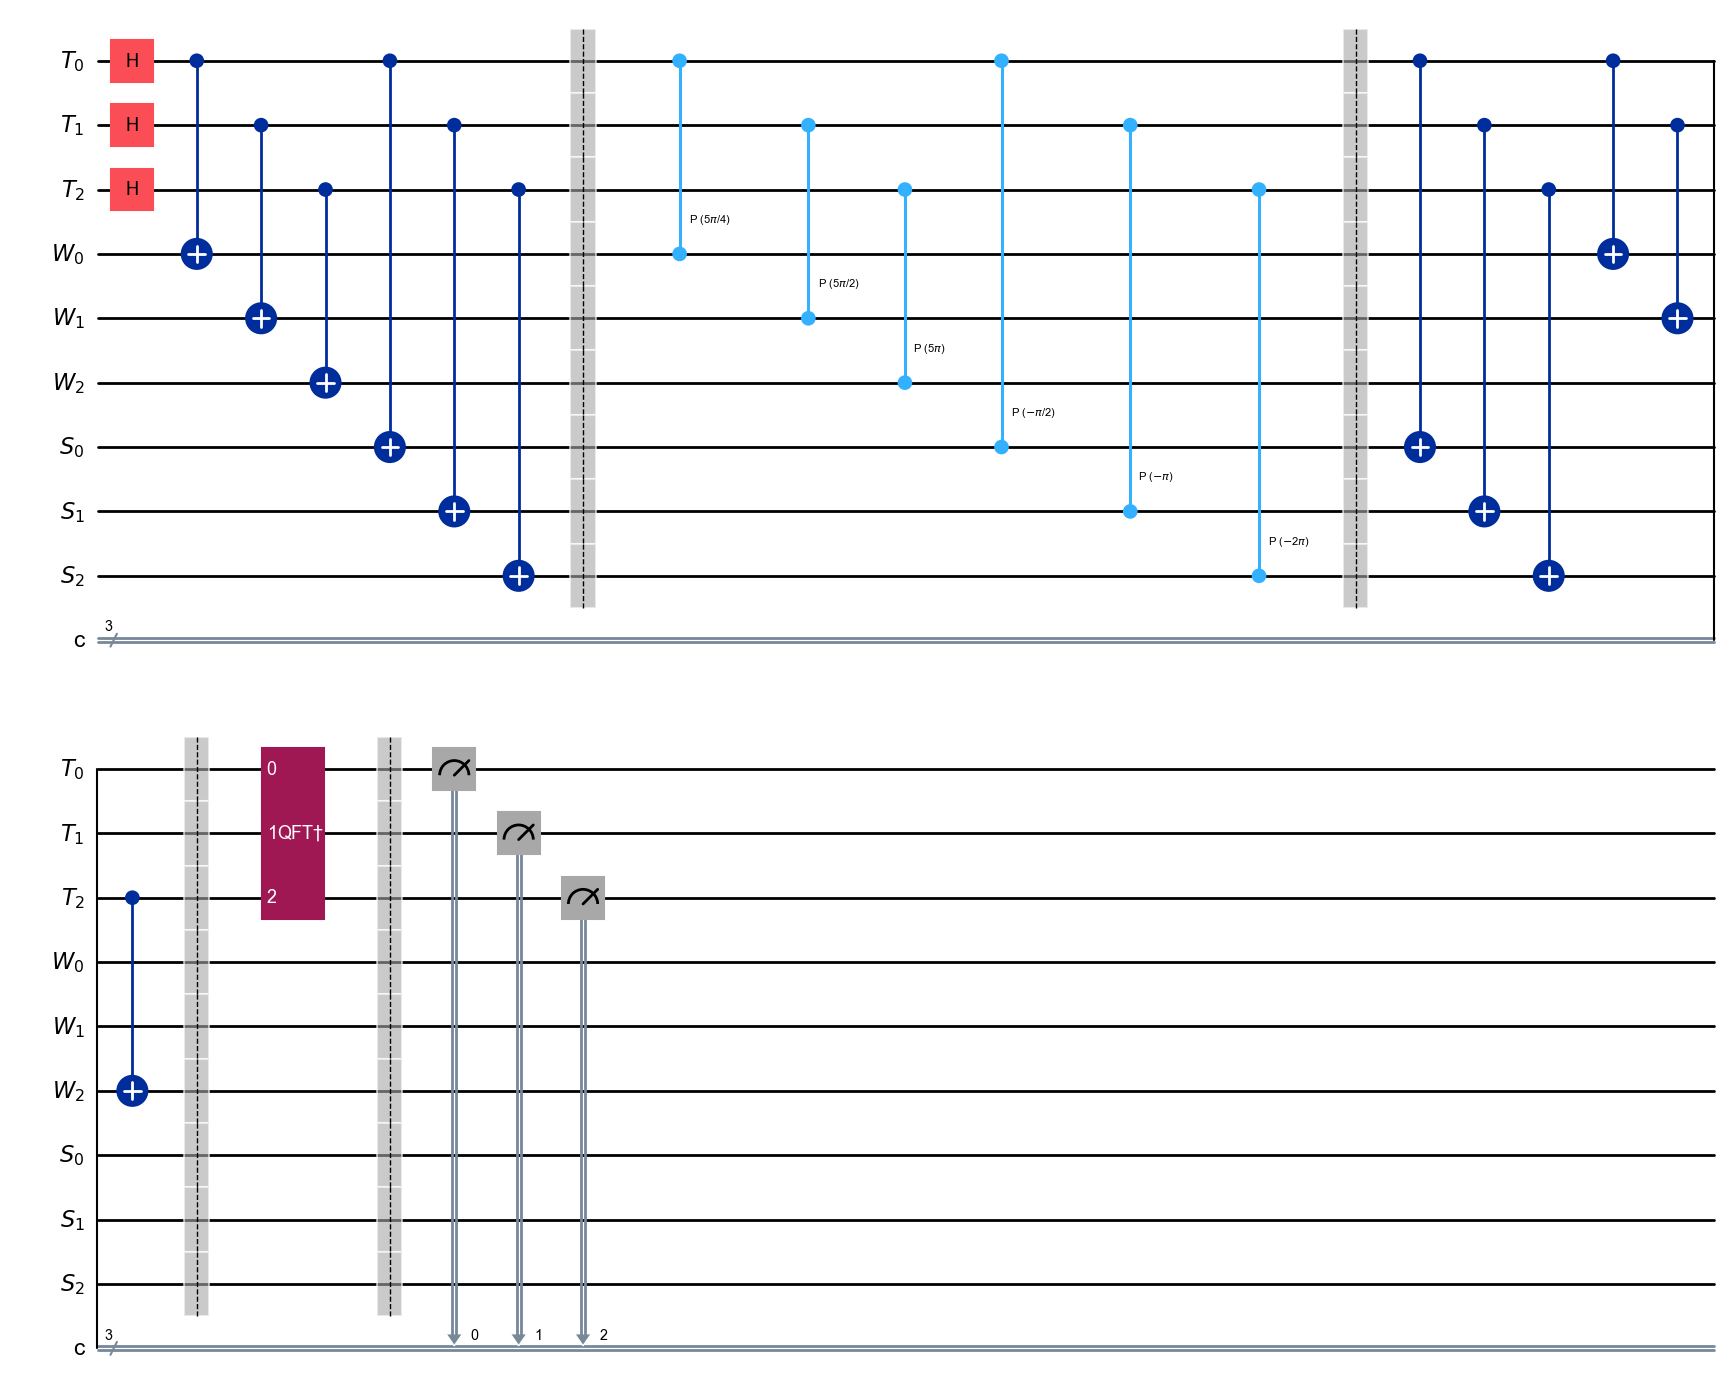

In [12]:
qc.draw("mpl")

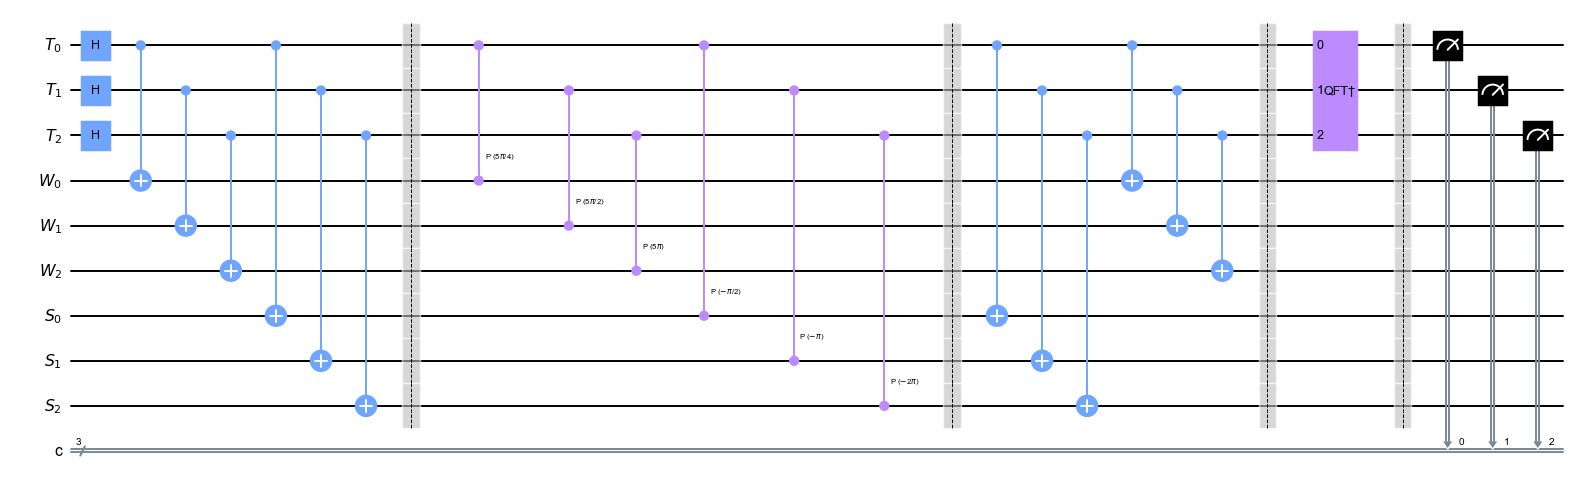

In [13]:
qc.draw('mpl', style='clifford', scale=0.7, fold=-1)